### RQ1 : Are our high level concepts redundant? Can some of the high level concepts be inferred by others?

In [7]:
# generic imports
import sys
import os
sys.path.append('../')
import helper
from definitions import *


import math
from collections import defaultdict
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

#stats amd ml
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn import feature_selection
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [8]:
survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'

In [9]:
def get_fig_size(figWidthPt):
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (math.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = figWidthPt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    return (fig_width,fig_height)

In [10]:
feature_df = pickle.load(open(os.path.join(survey_path, 'features-df.pkl'), 'rb'))

In [11]:
'''Use only two categories'''
feature_df = feature_df[(feature_df.label==1) | (feature_df.label==-1)]

In [113]:
feature_df.label

photo_no
1       1
10     -1
100     1
1000    1
1001   -1
1002    1
1003   -1
1005   -1
1006   -1
1007    1
1008   -1
1009    1
1010   -1
1011    1
1012    1
1013    1
1014    1
1015    1
1016    1
1019    1
1022   -1
1023    1
1024   -1
1025    1
1026   -1
1027    1
1028    1
1029    1
103    -1
1030    1
       ..
960     1
962     1
964     1
965     1
966     1
967     1
968     1
970    -1
971     1
972     1
974     1
975     1
977     1
978     1
979     1
98     -1
981     1
983     1
984    -1
985     1
986     1
987     1
988     1
989     1
99     -1
992    -1
994     1
997     1
998     1
999     1
Name: label, dtype: int64

In [461]:

high_level_concepts_name = {'was_aware_num':'Awareness', 'posing_num':'Pose',
                            'comfort_num':'Comfort', 'will_num':'Willingness', 
                            'photographer_intention_num':'Photographer intention',
                            'replacable_num':'Replacable', 'photo_place_num':'Photo place',
                            'person_size':'Size', 'person_distance_axes_norm':'Distance',
                            'num_people':'Number of people'}


'''
Correlation between pairs of features collected from survey and from annotations
'''
cor_df = []#defaultdict(list)
features = high_level_concepts_num+img_level_concepts
for i in range(len(features)):
    for j in range(i+1, len(features)):
        c = stats.pearsonr(feature_df[features[i]], feature_df[features[j]])
        if  math.fabs(c[0])>=.3 and c[1]<.05:
            print('Cor({},{}) = {:.2f} (p={:.2f})'.format(
                features[i], features[j], c[0], c[1]))
            
            d = dict()
            d['Var1']=high_level_concepts_name[features[i]]
            d['Var2']=high_level_concepts_name[features[j]]
            d['Correlation coefficient (r)']=c[0]
            cor_df.append(d)

cor_df =pd.DataFrame(cor_df)

Cor(was_aware_num,posing_num) = 0.88 (p=0.00)
Cor(was_aware_num,comfort_num) = 0.75 (p=0.00)
Cor(was_aware_num,will_num) = 0.79 (p=0.00)
Cor(was_aware_num,replacable_num) = -0.57 (p=0.00)
Cor(was_aware_num,person_size) = 0.45 (p=0.00)
Cor(was_aware_num,person_distance_axes_norm) = -0.37 (p=0.00)
Cor(posing_num,comfort_num) = 0.73 (p=0.00)
Cor(posing_num,will_num) = 0.76 (p=0.00)
Cor(posing_num,replacable_num) = -0.48 (p=0.00)
Cor(posing_num,person_size) = 0.42 (p=0.00)
Cor(posing_num,person_distance_axes_norm) = -0.34 (p=0.00)
Cor(comfort_num,will_num) = 0.86 (p=0.00)
Cor(comfort_num,replacable_num) = -0.49 (p=0.00)
Cor(comfort_num,person_size) = 0.37 (p=0.00)
Cor(comfort_num,person_distance_axes_norm) = -0.32 (p=0.00)
Cor(will_num,replacable_num) = -0.52 (p=0.00)
Cor(will_num,person_size) = 0.39 (p=0.00)
Cor(will_num,person_distance_axes_norm) = -0.33 (p=0.00)
Cor(replacable_num,person_size) = -0.44 (p=0.00)
Cor(replacable_num,person_distance_axes_norm) = 0.42 (p=0.00)
Cor(replacable_

In [ ]:
cor_df.set_index(['Var1','Var2'], inplace=True)
print(cor_df.round(2).to_latex())

In [ ]:
helper.plot_corr_matrix(mat=feature_df[high_level_concepts_num].corr(),
                title='Correlation between pairs of collected variables')

In [ ]:
'''Calculating MI for individual pairs just to check with the following mi_matrix'''
for i in range(len(high_level_concepts)):
    for j in range(i+1, len(high_level_concepts)):
        mi =feature_selection.mutual_info_regression(feature_df[high_level_concepts_num[i]].values.reshape(-1,1),
                                                  feature_df[high_level_concepts_num[j]].values,
                                                  discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
        if mi[0]>=1:
            print('MI({}, {}) = {:.2f}'.format(high_level_concepts_num[i], high_level_concepts_num[j], mi[0]))

In [ ]:
'''
Find mutual information between pairs of variables
'''
mi_matrix = np.zeros((len(high_level_concepts),len(high_level_concepts)), dtype=float)
for i in range(len(high_level_concepts)):
    for j in range(0, len(high_level_concepts)):
        mi =feature_selection.mutual_info_regression(feature_df[high_level_concepts_num[i]].values.reshape(-1,1),
                                                  feature_df[high_level_concepts_num[j]].values,
                                                  discrete_features=[True], n_neighbors=3, copy=True, random_state=None)
        mi_matrix[i][j] = mi[0]
        
        #uncomment below line to test correctness 
        #print(high_level_concepts[i], high_level_concepts[j], mi[0])

pd.DataFrame(mi_matrix, columns=high_level_concepts, index=high_level_concepts)

In [ ]:
helper.plot_corr_matrix(mat=mi_matrix, ticks=high_level_concepts,
                 title='Mutual Information between pairs of collected variables')

### PCA

In [7]:
feature_df[img_level_concepts].corr()

,person_size,person_distance_axes_norm,num_people
person_size,1.000000,-0.480529,-0.425859
person_distance_axes_norm,-0.480529,1.000000,0.261826
num_people,-0.425859,0.261826,1.000000


In [8]:
'''The image level features have '''
concepts=[#'was_aware_num',
 'posing_num',
 'comfort_num',
 'will_num',
 'photographer_intention_num',
 'replacable_num',
 'photo_place_num']

all_high_level_concepts=concepts+img_level_concepts
normalized_data = feature_df[all_high_level_concepts].apply(stats.zscore)
normalized_data.to_csv(survey_path+'high-feature-df-normalized.csv')

In [9]:
n_comp = len(all_high_level_concepts)
pca = PCA(n_components=n_comp).fit(normalized_data.values)
pca.explained_variance_ratio_,np.cumsum(pca.explained_variance_ratio_)

(array([ 0.42855184,  0.13073324,  0.11408802,  0.09202016,  0.08183971,
         0.05653316,  0.04948294,  0.03206728,  0.01468365]),
 array([ 0.42855184,  0.55928507,  0.6733731 ,  0.76539325,  0.84723297,
         0.90376612,  0.95324907,  0.98531635,  1.        ]))

In [14]:
labelFont = 18
legendFont = 16
tickFont = 16

manuscriptColSize= 252
forLatex = True
latexDec = 6

In [293]:
%matplotlib inline

def plot_scree(forLatex = False):

    fig = plt.figure(figsize=(12,8))

    if(forLatex):
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif', serif='Times')
        fig.set_size_inches(get_fig_size(manuscriptColSize))

    plt.plot(range(1,1+n_comp), np.cumsum(pca.explained_variance_ratio_), 'o--', 
             color='orange', linewidth=2, label='cum. var. explained')
    plt.plot(range(1,1+n_comp), pca.explained_variance_ratio_, 'o-', linewidth=2 ,label='var. explained')
    plt.legend(fontsize=legendFont-forLatex*latexDec, markerscale=0.75, loc=0, frameon=True)
    plt.xlabel('Components',fontsize=labelFont-forLatex*latexDec)
    plt.ylabel('Variance explained',fontsize=labelFont-forLatex*latexDec)
    plt.xticks(range(1,1+n_comp), fontsize=tickFont-forLatex*latexDec)
    plt.yticks([0,.2,.4,.6,.8,1], fontsize=tickFont-forLatex*latexDec)

    if(forLatex):
        plt.tight_layout()
        plt.savefig(survey_path+'scree-plot.pdf',dpi=100)
    else:
        plt.show()

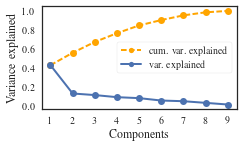

In [587]:
plot_scree(forLatex=True)

In [149]:
# plt.figure(figsize=(8,8))
# for v in high_level_concepts_num:
#     plt.scatter(x=component_matrix.T.loc[0][v],y=component_matrix.T.loc[1][v], 
#                 marker='o', label=v, s=70)
#     plt.text(s=v,x=component_matrix.T.loc[0][v]+.01,
#              y=component_matrix.T.loc[1][v]+.01)

# #plt.legend()
# plt.axhline(y=0)
# plt.axvline(x=0)
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()
survey_path

'/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'

### Factor analysis

In [28]:
from factor_analyzer import FactorAnalyzer

In [380]:
import math
def plot_loadings(loadings, items, threshold=.3, save_file=None, forLatex=False):
    markers = list("ovd^<>hp+x")
    colors = ['b', 'c', 'y', 'm', 'lightcoral', 'cornflowerblue','violet','teal']
    fig = plt.figure()
    if(forLatex):
        print('setting latex size')
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif', serif='Times')
        w, h =get_fig_size(manuscriptColSize)
        fig.set_size_inches((w,w))
    else:
        fig.set_size_inches((8,8))
        
#     ax = fig.add_subplot(111)
#     ax.yaxis.tick_right()
        
    i=0
    for v in items:
        if math.fabs(loadings.loc[0][v])>=threshold or math.fabs(loadings.loc[1][v])>=threshold:
            x=loadings.loc[0][v]
            y=loadings.loc[1][v]
            label = v+'\n({:.2f},{:.2f})'.format(x,y) if v=='Number of people' else v+' ({:.2f},{:.2f})'.format(x,y)
            plt.scatter(x, y, marker=markers[i], 
                        label= label,
                        s=90, color=colors[i])
            i+=1
    plt.axhline(y=0, linestyle='--', color='lightgray')
    plt.axvline(x=0, linestyle='--', color='lightgray')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xticks(np.arange(-1,1.25,.25), fontsize=tickFont-forLatex*latexDec-2, rotation=90)
    plt.yticks(np.arange(-1,1.25,.25), fontsize=tickFont-forLatex*latexDec-2)
    #plt.tick_params(labelsize= tickFont-forLatex*latexDec-2)
    plt.xlabel('Factor1',fontsize=labelFont-forLatex*latexDec-2)
    plt.ylabel('Factor2',fontsize=labelFont-forLatex*latexDec-2)
    plt.legend(fontsize=legendFont-forLatex*latexDec-2, markerscale=0.4, loc=2, 
            handletextpad=.01, bbox_to_anchor=(-0.03, 1.02),
          ncol=1, frameon=True#,fancybox=True, shadow=True
              )
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file,dpi=300)
    plt.show()


def clarify_loadings(df, threshold=.3):
    df = df.round(2).T
    for c in df.columns:
        df[c] = np.where((df[c]<threshold)&(df[c]>-threshold), '', df[c])
    return df.round(2)

In [1]:
fa = FactorAnalyzer(rotation='varimax', n_factors=3)
fa.fit(normalized_data)
loadings = pd.DataFrame(fa.loadings_.T, columns=all_high_level_concepts)
loadings = loadings.rename(columns=high_level_concepts_name)

plot_loadings(loadings,[high_level_concepts_name[k] for k in all_high_level_concepts],threshold=.4, forLatex=True)

#loadings=clarify_loadings(loadings).rename(columns=high_level_concepts_name)
#loadings

NameError: name 'FactorAnalyzer' is not defined

In [382]:
concepts=[#'was_aware_num',
 'posing_num',
 'comfort_num',
 'will_num',
 'photographer_intention_num',
 'replacable_num',
 'photo_place_num']

all_high_level_concepts=concepts+img_level_concepts
normalized_data = feature_df[all_high_level_concepts].apply(stats.zscore)

setting latex size


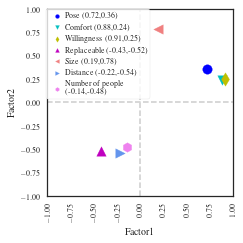

,0,1
Pose,0.72,0.36
Comfort,0.88,
Willingness,0.91,
Photographer intention,,
Replaceable,-0.43,-0.52
Photo place,,0.3
Size,,0.78
Distance,,-0.54
Number of people,,-0.48


In [383]:

fa = FactorAnalyzer(rotation='varimax', n_factors=2)
fa.fit(normalized_data)
loadings = pd.DataFrame(fa.loadings_.T, columns=all_high_level_concepts)
loadings = loadings.rename(columns=high_level_concepts_name)
plot_loadings(loadings,[high_level_concepts_name[k] for k in all_high_level_concepts],
              threshold=.4, save_file=survey_path+'fa-plot.pdf', forLatex=True)

loadings=clarify_loadings(loadings).rename(columns=high_level_concepts_name)
loadings

In [369]:
# Detect multicollinearity

## Using VIF

In [ ]:
'''Use all variables'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

normalized_data = feature_df[high_level_concepts_num+img_level_concepts].apply(stats.zscore)

normalized_data=add_constant(normalized_data)
s = pd.Series([variance_inflation_factor(normalized_data.values, i) 
               for i in range(normalized_data.shape[1])], 
              index=normalized_data.columns)
print(s.T.to_latex())
s.T

In [ ]:
'''remove aware'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

concepts=[#'was_aware_num',
 'posing_num',
 'comfort_num',
 'will_num',
 'photographer_intention_num',
 'replacable_num',
 'photo_place_num']

all_high_level_concepts=concepts+img_level_concepts
normalized_data = feature_df[all_high_level_concepts].apply(stats.zscore)

normalized_data=add_constant(normalized_data)
s=pd.Series([variance_inflation_factor(normalized_data.values, i) 
               for i in range(normalized_data.shape[1])], 
              index=normalized_data.columns)
s.round(2)

### Using Regression or *How one concept is explained by all the others*

In [ ]:
rsq_df=[]
features = high_level_concepts_num+img_level_concepts
for c in features:
    X = feature_df[list(set(features).difference(set([c])))]
    X = sm.add_constant(X)
    y = feature_df[c]
    est = sm.OLS(y, X).fit()
    rsq_df.append({'Variable':high_level_concepts_name[c], 'Adjusted Rsq.':est.rsquared_adj})
    print(est.summary())
    print('\n\n')

In [ ]:
print(pd.DataFrame(rsq_df).round(2).set_index('Variable').to_latex())

In [ ]:
binary_data = feature_df[(feature_df.label==1) | (feature_df.label==-1)]
binary_data['label'] = binary_data.apply(lambda row: 1 if row.label==1 else 0, axis=1)
X = binary_data[['posing_num','photographer_intention_num']]
X = sm.add_constant(X)
y = binary_data.label
est = sm.Logit(endog=y, exog=X).fit()
print(est.summary())

In [ ]:
est.summary2()

In [ ]:
img_level_concepts

In [ ]:
survey_path

### ROC Plots for paper

In [121]:
import cv2 

In [3]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc,accuracy_score
from scipy import interp
from sklearn import cross_validation, grid_search

'''Feature names'''

#joint names labeled by openpose
body_joint_names = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb',
               'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 
               'Leye', 'Reye', 'Lear', 'Rear']

#angles between pairs of body joint, from openpose
link_angle_features = ['angle_'+str(i) for i in range(17)]

#probability of detecting a body joint, from openpose
body_joint_prob_features = [j + '_prob' for j in body_joint_names]

face_exp_feaures = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

img_level_features = ['person_distance_axes_norm', 'person_size', 'num_people']

visual_features = img_level_features +\
    link_angle_features + body_joint_prob_features + face_exp_feaures

features_from_study = ['was_aware_num',  'posing_num',  'comfort_num',  'will_num', 'photographer_intention_num',
     'replacable_num',  'photo_place_num']

resnet_feature_cols = ['resnet_feat_{}'.format(i) for i in range(131071)]

resnet_feat_avg_cols = ['resnet_feat_avg_{}'.format(i) for i in range(2048)]

all_features = features_from_study + visual_features + resnet_feat_avg_cols
#img_level_features = ['person_distance', 'person_size', 'num_people']

/l/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/l/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [110]:
print('Loading cropped images')

cropped_img = dict()
IMG_SIZE = (256, 256)
image_names = list(set(feature_df.index.values))
for idx in image_names:
    cropped_img[idx] = cv2.resize(cv2.imread(survey_path+'cropped-photos/'+idx+'.jpg'), 
                   dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
feature_df['resized_cropped_img'] = pd.Series(cropped_img)

print('Loading ResNet features')
rn = pickle.load(open(survey_path+'resnet_features_averaged.pkl','rb'))
rn_dicts = []
for k in rn.keys():
    feats = rn[k]
    d= {'photo_no':k}
    for i in range(len(resnet_feat_avg_cols)):
        d[resnet_feat_avg_cols[i]] = feats[0][i]
    rn_dicts.append(d)
rn_df = pd.DataFrame(rn_dicts)
rn_df = rn_df.loc[feature_df.index]
rn_df.set_index('photo_no', inplace=True)
feature_df= pd.concat([feature_df, rn_df], axis=1)

In [114]:
# def plot_roc(data, show_plot = True, file_to_save=None, for_latex=False, square=False):
#     plt.rcParams["axes.edgecolor"] = "black"
#     plt.rcParams["axes.linewidth"] = 1
#     fig= plt.figure(facecolor='w')
#     plt.fill(False)
    
#     for fpr, tpr in data:
#         plt.plot(fpr, tpr, lw=1, alpha=0.3, 
#                  label=None)#'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


def do_cross_val_roc(X, y, classifier_func, n_splits=10, 
                     show_plot=True, save_file=None,
                        forLatex=False,
                        square=False #whether the plot is square or rectangular
                    ):
    '''
    Cross validation for a Logistic Regression model and plot ROC.    
    This was copied from the helper, to change plotting
    '''
    random_state = np.random.RandomState(0)
    cv_scores = []
    #
    cv = StratifiedKFold(n_splits=n_splits)
    #
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    #
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    fig= plt.figure(facecolor='w')
    plt.fill(False)
    if(forLatex):
        print('setting latex size')
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif', serif='Times')
        w,h = get_fig_size(manuscriptColSize)
        fig_size = ((w, w if square else h))
        fig.set_size_inches(fig_size)
    else:
        fig.set_size_inches((12,8))
#
    i = 0
    for train, test in cv.split(X, y):
        print('Fold: ', i)
        trained_classifier = classifier_func().fit(X[train], y[train])
        trained_classifier.random_state = random_state
        trained_classifier.probability=True
        predictions = trained_classifier.predict(X[test])
        cv_scores.append(accuracy_score(y_pred=predictions, y_true=y[test]))
        print(classification_report(y_pred=predictions, y_true=y[test]))
        
        probas_ = trained_classifier.predict_proba(X[test])
        # Compute ROC curve and area of the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, 
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
#
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', 
             alpha=.8)
#
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
#
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                     label=r'$\pm$ 1 std. dev.')
#
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=labelFont-forLatex*latexDec-2)
    plt.ylabel('True Positive Rate', fontsize=labelFont-forLatex*latexDec-2)
    #plt.text(.15,.03, 'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'% (mean_auc, std_auc))
    plt.legend(fontsize=legendFont-forLatex*latexDec-2, markerscale=0.4, loc="lower right", frameon=True)
#             handletextpad=.01, bbox_to_anchor=(-0.03, 1.02),
#           ncol=1, frameon=True#,fancybox=True, shadow=True
       
    #fig.patch.set_color('w')
    fig.set_facecolor("w")
    
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file, dpi=300, frameon=True, facecolor=fig.get_facecolor(), edgecolor='black', transparent=True)
    if show_plot:
        plt.show()
    #
    print('Accuracy scores:',cv_scores)
    print('Mean accuracy:{}(+/-{:.2f})'.format(np.mean(cv_scores), np.std(cv_scores)))

setting latex size
Fold:  0
             precision    recall  f1-score   support

         -1       0.90      0.86      0.88       152
          1       0.91      0.93      0.92       229

avg / total       0.90      0.90      0.90       381

Fold:  1
             precision    recall  f1-score   support

         -1       0.86      0.71      0.78       152
          1       0.83      0.93      0.87       229

avg / total       0.84      0.84      0.84       381

Fold:  2
             precision    recall  f1-score   support

         -1       0.87      0.91      0.89       152
          1       0.94      0.91      0.92       229

avg / total       0.91      0.91      0.91       381

Fold:  3
             precision    recall  f1-score   support

         -1       0.84      0.86      0.85       152
          1       0.91      0.89      0.90       229

avg / total       0.88      0.88      0.88       381

Fold:  4
             precision    recall  f1-score   support

         -1       0.84

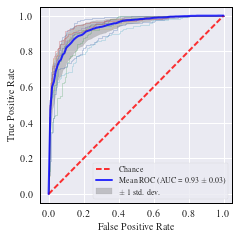

Accuracy scores: [0.90288713910761154, 0.83989501312335957, 0.91076115485564302, 0.87926509186351709, 0.884514435695538, 0.79210526315789476, 0.79473684210526319, 0.87071240105540892, 0.87071240105540892, 0.8812664907651715]
Mean accuracy:0.8626856232784815(+/-0.04)


In [115]:
min_max_scaler = preprocessing.MinMaxScaler()

'''This will be used in paper'''
'''Use selected survey features and size, location, and number of people as predictors'''
feat=['posing_num', 'replacable_num', 'photographer_intention_num','person_size']
do_cross_val_roc(classifier_func=LogisticRegression,
                    X= min_max_scaler.fit_transform(
                    feature_df[feat]),
                    y=feature_df.label, n_splits=10,
                    save_file=survey_path+'ground-truth-pose-roc.pdf',
                    forLatex=True,
                     square=True
                    )

/l/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


setting latex size
             precision    recall  f1-score   support

         -1       0.59      0.66      0.63       152
          1       0.76      0.69      0.72       229

avg / total       0.69      0.68      0.68       381

             precision    recall  f1-score   support

         -1       0.61      0.65      0.63       152
          1       0.76      0.73      0.74       229

avg / total       0.70      0.70      0.70       381

             precision    recall  f1-score   support

         -1       0.59      0.59      0.59       152
          1       0.73      0.72      0.73       229

avg / total       0.67      0.67      0.67       381

             precision    recall  f1-score   support

         -1       0.53      0.59      0.56       152
          1       0.71      0.65      0.68       229

avg / total       0.64      0.63      0.63       381

             precision    recall  f1-score   support

         -1       0.55      0.61      0.57       152
          1   

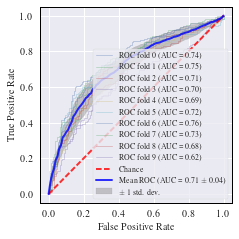

Accuracy scores: [0.6824146981627297, 0.69816272965879267, 0.67191601049868765, 0.62729658792650922, 0.64304461942257218, 0.66315789473684206, 0.69473684210526321, 0.70184696569920846, 0.64116094986807393, 0.60686015831134565]
Mean accuracy:0.6630597456390025(+/-0.03)


In [112]:
do_cross_val_roc(classifier_func=LogisticRegression,
                    X= min_max_scaler.fit_transform(
                       np.array([x.flatten() for x in feature_df.resized_cropped_img])),
                    y=feature_df.label,
                    n_splits=10,
                    forLatex=True,
                    square=True,
                    save_file=survey_path+'raw-cropped-img-roc.pdf')

In [128]:
feature_df =pd.read_pickle(os.path.join(survey_path, 'all-features-df-'+str(datetime.now().date())+'.pkl'))

setting latex size
Fold:  0
             precision    recall  f1-score   support

         -1       0.75      0.78      0.76       152
          1       0.85      0.83      0.84       229

avg / total       0.81      0.81      0.81       381

Fold:  1
             precision    recall  f1-score   support

         -1       0.75      0.68      0.72       152
          1       0.80      0.85      0.83       229

avg / total       0.78      0.78      0.78       381

Fold:  2
             precision    recall  f1-score   support

         -1       0.78      0.70      0.74       152
          1       0.81      0.87      0.84       229

avg / total       0.80      0.80      0.80       381

Fold:  3
             precision    recall  f1-score   support

         -1       0.71      0.72      0.71       152
          1       0.81      0.80      0.81       229

avg / total       0.77      0.77      0.77       381

Fold:  4
             precision    recall  f1-score   support

         -1       0.72

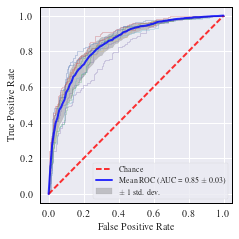

Accuracy scores: [0.80839895013123364, 0.78477690288713908, 0.80052493438320205, 0.76902887139107612, 0.76640419947506566, 0.77105263157894732, 0.7868421052631579, 0.78627968337730869, 0.82585751978891819, 0.70976253298153036]
Mean accuracy:0.780892833125758(+/-0.03)


In [129]:
#feat=['posing_num', 'replacable_num', 'photographer_intention_num','person_size']
do_cross_val_roc(classifier_func=LogisticRegression,
                   X=  min_max_scaler.fit_transform(feature_df_merged[resnet_feat_avg_cols+body_joint_prob_features+\
                                link_angle_features+ face_exp_feaures]),
                   y=feature_df_merged.label, n_splits=10,
                 forLatex=True,
                 square=True,
                  save_file=survey_path+'all-visual-features-roc.pdf')

['person_distance_axes_norm', 'person_size', 'num_people']
setting latex size
Fold:  0
             precision    recall  f1-score   support

         -1       0.72      0.72      0.72       152
          1       0.81      0.82      0.81       229

avg / total       0.78      0.78      0.78       381

Fold:  1
             precision    recall  f1-score   support

         -1       0.75      0.64      0.69       152
          1       0.78      0.86      0.82       229

avg / total       0.77      0.77      0.77       381

Fold:  2
             precision    recall  f1-score   support

         -1       0.72      0.67      0.70       152
          1       0.79      0.83      0.81       229

avg / total       0.76      0.77      0.76       381

Fold:  3
             precision    recall  f1-score   support

         -1       0.71      0.69      0.70       152
          1       0.80      0.82      0.81       229

avg / total       0.77      0.77      0.77       381

Fold:  4
             prec

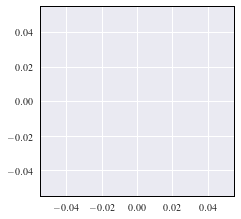

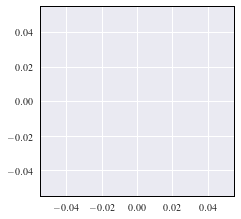

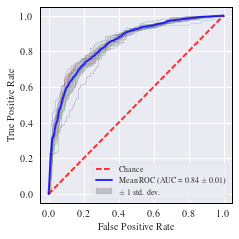

Accuracy scores: [0.7769028871391076, 0.76902887139107612, 0.76640419947506566, 0.76640419947506566, 0.78477690288713908, 0.76052631578947372, 0.80000000000000004, 0.74670184696569919, 0.76517150395778366, 0.75197889182058042]
Mean accuracy:0.7687895618900991(+/-0.01)


In [120]:
'''Simple predictors'''
print(img_level_features)
do_cross_val_roc(classifier_func=LogisticRegression,
                   X= feature_df[img_level_features].apply(stats.zscore).values,
                   y=feature_df.label, n_splits=10,
                     forLatex=True,
                 square=True,
                    save_file=survey_path+'simple-predictor-roc.pdf')

### Comparing with human

In [100]:
agreement_23 = pickle.load(open(survey_path+'agreement23.pkl','rb'))
agreement_100 = pickle.load(open(survey_path+'agreement100.pkl','rb'))

setting latex size
             precision    recall  f1-score   support

         -1       0.84      0.59      0.70        54
          1       0.77      0.92      0.84        78

avg / total       0.80      0.79      0.78       132

             precision    recall  f1-score   support

         -1       0.80      0.80      0.80        54
          1       0.86      0.86      0.86        78

avg / total       0.83      0.83      0.83       132

             precision    recall  f1-score   support

         -1       0.79      0.83      0.81        54
          1       0.88      0.85      0.86        78

avg / total       0.84      0.84      0.84       132

             precision    recall  f1-score   support

         -1       0.78      0.87      0.82        54
          1       0.90      0.83      0.87        78

avg / total       0.85      0.85      0.85       132

             precision    recall  f1-score   support

         -1       0.70      0.79      0.74        53
          1   

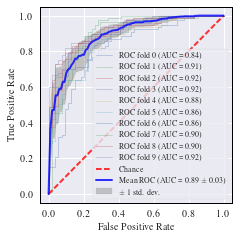

Accuracy scores: [0.78787878787878785, 0.83333333333333337, 0.84090909090909094, 0.84848484848484851, 0.77692307692307694, 0.79230769230769227, 0.74615384615384617, 0.84615384615384615, 0.81538461538461537, 0.80000000000000004]
Mean accuracy:0.8087529137529138(+/-0.03)


In [108]:
'''
Split 67% agreement data for training and testing
'''
feat=['posing_num', 'replacable_num', 'photographer_intention_num','person_size']

df = feature_df.loc[agreement_23][feat+['label']]
do_cross_val_roc(classifier_func=LogisticRegression,
                   X= df[feat].apply(stats.zscore).values,
                   y=df.label, n_splits=10,
                    forLatex=True,
                 square=True,
                    save_file=survey_path+'67-perc-agreement-roc.pdf')

setting latex size
             precision    recall  f1-score   support

         -1       0.97      0.77      0.86        48
          1       0.88      0.99      0.93        84

avg / total       0.92      0.91      0.91       132

             precision    recall  f1-score   support

         -1       0.98      0.98      0.98        47
          1       0.99      0.99      0.99        84

avg / total       0.98      0.98      0.98       131

             precision    recall  f1-score   support

         -1       0.96      0.98      0.97        47
          1       0.99      0.98      0.98        84

avg / total       0.98      0.98      0.98       131

             precision    recall  f1-score   support

         -1       0.88      0.98      0.93        47
          1       0.99      0.93      0.96        84

avg / total       0.95      0.95      0.95       131

             precision    recall  f1-score   support

         -1       0.90      0.91      0.91        47
          1   

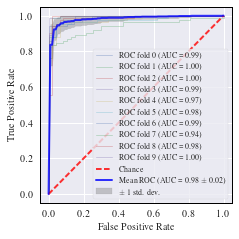

Accuracy scores: [0.90909090909090906, 0.98473282442748089, 0.97709923664122134, 0.94656488549618323, 0.93129770992366412, 0.93129770992366412, 0.95419847328244278, 0.87022900763358779, 0.9538461538461539, 0.97692307692307689]
Mean accuracy:0.9435279987188384(+/-0.03)


In [109]:
'''
Split 100% agreement data for training and testing
'''
feat=['posing_num', 'replacable_num', 'photographer_intention_num','person_size']

df = feature_df.loc[agreement_100][feat+['label']]
do_cross_val_roc(classifier_func=LogisticRegression,
                   X= df[feat].apply(stats.zscore).values,
                   y=df.label, n_splits=10,
                    forLatex=True,
                    square=True,
                    save_file=survey_path+'100-perc-agreement-roc.pdf')

In [613]:
feature_df.to_pickle(os.path.join(survey_path, 'features-df-all-'+str(datetime.now().date())+'.pkl'))

In [614]:
survey_path

'/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'

In [615]:
feature_df.to_csv(os.path.join(survey_path, 'features-df-all.csv'))

In [123]:
from datetime import datetime

In [131]:
1045/60

17.416666666666668